In [1]:
from labgraph import Sample, Material, Action, Measurement, Analysis, Ingredient, WholeIngredient, Actor
import labgraph.views as views
from labgraph.utils.dev import drop_collections
from labgraph.utils import make_config

In [2]:
make_config(
    db_name="labgraph_demo"
)
drop_collections()


Config file successfully written to /Users/rishikumar/GitHub/labgraph/labgraph/utils/config/labgraph_config.toml. 


# 1. Defining Actors and AnalysisMethods 

These entries allow us to track which hardware, software, and operators are performing tasks within the experimental database.

`Actor`s perform synthesis `Action`s and `Measurements`. `AnalysisMethods` convert raw `Measurement`s into some useful metrics

You only need to _add_ `Actor`s and `AnalysisMethods` once. In the future, you can pull these entries from the database to relate them to incoming data

Add or pull all Actor's from the ActorView

In [3]:
actorview = views.ActorView() #this is our interface to the Actor database collection

In [4]:
actorview.get_by_tags(["SolidStateALab"]) #nothing yet


NotFoundInDatabaseError: Cannot find a Actor with tags: ['SolidStateALab']

In [5]:
labman = Actor(
    name="LabMan 30-105", 
    tags=["SolidStateALab"],
    description="A robotic system that weighs and mixes powders in crucibles. Used to prepare samples for firing in furnaces. This is in building 30-105 at Lawrence Berkeley National Laboratory.")

tubefurnace1 = Actor(
    name="TubeFurnace1 30-105", 
    tags=["SolidStateALab"],
    description="A tube furnace in building 30-105 at Lawrence Berkeley National Laboratory.")

aeris = Actor(
    name="Aeris 30-105",
    tags=["SolidStateALab"],
    description="An x-ray diffractometer. This is in building 30-105 at Lawrence Berkeley National Laboratory.")

operator = Actor(
    name="Operator",
    description = "A generic actor for any operation performed by a human. No need to name names!")

cnn_phaseID = Actor(
    name="CNN Phase ID", 
    tags=["SolidStateALab", "machinelearning"],
    description="A convolutional neural network trained to identify phases in x-ray diffraction patterns. doi: something/something")

for actor in [labman, tubefurnace1, aeris, operator, cnn_phaseID]:
    actorview.add(actor)

In [6]:
actorview.get_by_tags(["SolidStateALab"])   #now we can find actors by tags

[<Actor: LabMan 30-105 v1>,
 <Actor: TubeFurnace1 30-105 v1>,
 <Actor: Aeris 30-105 v1>,
 <Actor: CNN Phase ID v1>]

In [7]:
labman = actorview.get_by_name("LabMan 30-105")
labman

[<Actor: LabMan 30-105 v1>]

In [8]:
actorview.filter(
    {"name": "LabMan 30-105",
     "tags": "SolidStateALab"
}) #if you are comfortable with MongoDB queries, you can use the filter method

AttributeError: 'ActorView' object has no attribute 'filter'

# 2. Entering experimental data into the database

First, we must define the individual nodes (`Action`, `Material`, `Measurement`, and `Analysis`) that will comprise the experimental steps and data for a given `Sample`

In [9]:
m0 = Material(
    name="Titanium Dioxide",
    formula="TiO2",
)

p0 = Action(    
    name="procurement",
    generated_materials=[m0],
    actor=operator,
)

In [10]:
p1 = Action(
    "grind",
    ingredients = [
        Ingredient(
            material=m0,
            amount=1,
            unit="g",
        )
    ],
    actor=operator,
    )
m1 = p1.make_generic_generated_material()

p2 = Action("sinter", ingredients = [WholeIngredient(m1)], actor=tubefurnace1)
m2 = p2.make_generic_generated_material()

p3 = Action("grind", ingredients = [WholeIngredient(m2)], actor=operator, final_step=True)
m3 = p3.make_generic_generated_material()

me0 = Measurement(
    name="XRD",
    material=m3,
    actor=aeris,
)

a0 = Analysis(
    name="Phase Identification",
    measurements=[me0],
    actor=cnn_phaseID
)

Next, we will assign these nodes to a single `Sample`. This can be done manually in a few ways:

In [11]:
all_nodes = [p0, m0, p1, m1, p2, m2, p3, m3, me0, a0]

#if you have all nodes beforehand
s = Sample(name="first_sample", nodes=all_nodes)

#if you build nodes as you go. Maybe you want to build up the Sample object during the experiment?
s = Sample(name="first_sample_again")
for n in all_nodes:
    s.add_node(n)

We can check that the nodes within the Sample constitute a valid directed acyclic graph (DAG).

If this returns `False`, we didn't connect the nodes correctly.

True


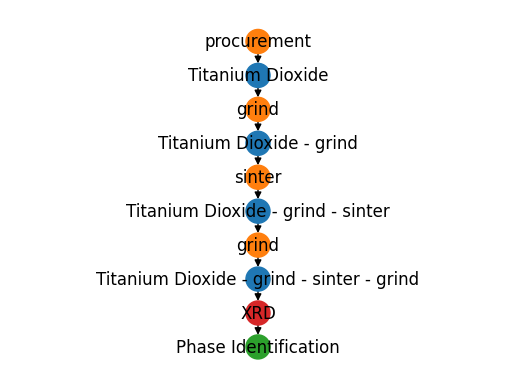

In [12]:
print(s.has_valid_graph)
s.plot()

Up til now, the `Sample` object only lives in this notebook. Now we need to upload it into the database.

`SampleView.add(sample)` does a few things. 

- First, it ensures that new nodes will not break the graph structures of the total database (at this point, ensures no dangling nodes)
- Second, it uploads the individual nodes into their respective collections
- Finally, it uploads the `Sample` entry to the sample collection, which maps the `Sample` to the individual nodes.

In [13]:
from labgraph.views.sample import SampleView
sv = SampleView()

sv.add(s)

ObjectId('64fa83325924b71da9cb1137')

In [14]:
s1 = sv.get_by_id(s.id)

In [15]:
sv.get_by_name("first_sample_again")

[<Sample: first_sample_again>]

In [16]:
s1 == s

True

We cannot add the same sample twice. If you have duplicate samples, you should rebuild a new `Sample` object instance.

In [17]:
sv.add(s1)

AlreadyInDatabaseError: Sample (name=first_sample_again, id=64fa83325924b71da9cb1137) already exists in the database!

## Shortcut to building `Sample`'s with a simple, linear process

As experimentalists, we often only know the initial `Material`'s and the sequence of synthesis `Action`'s. This is a simple linear graph, for which we have a shortcut method to skip the tedium of generating intermediate `Material`'s with which we do nothing.

Define your `Action`s as well as you can (_ie_ fill in the ingredients and generated_materials wherever possible). The rest will be filled in with generic, placeholder `Material`'s to stitch the `Action`'s into a valid graph.

In [18]:
# I know the starting material quite well, so I define it as usual.
m0 = Material(
    name="Titanium Dioxide",
    formula="TiO2",
)

p0 = Action(    
    name="procurement",
    generated_materials=[m0],
    actor=operator,
)

In [19]:
# I know what was done by which actors, but thats about it.
p1 = Action(
    "grind",
    actor=operator,
    )
p2 = Action("sinter", actor=tubefurnace1)
p3 = Action("grind", actor=operator, final_step=True)

Now I can use the shortcut to build the linear `... Action -> Material -> Action ...` graph.

In [20]:
# I know that the processes will generate materials in a pipeline, so lets add them as a linear process
s = Sample(name="shortcut_sample")
s.add_linear_process(actions=[p0, p1, p2, p3])

True


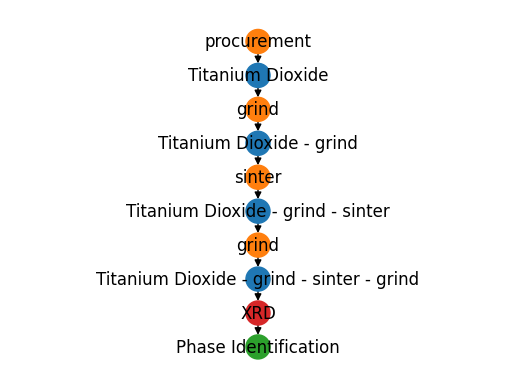

In [21]:
# I also know that I measured the output of the linear process. This is the latest node in the graph -- the output Material from the final Action.

m_final = s.nodes[-1]

me0 = Measurement(
    name="XRD",
    material=m_final,
    actor=aeris,
)

a0 = Analysis(
    name="Phase Identification",
    measurements=[me0],
    actor=cnn_phaseID
)

s.add_node(me0)
s.add_node(a0)
print(s.has_valid_graph)
s.plot()

In [22]:
sv.add(s)

ObjectId('64fa83385924b71da9cb1179')

-----

# 3. A realistic example

In the prior examples, only the required information has been provided to generate the experiment graph + add to the database. In real life, we want to attach metadata (process parameters, measured data, etc) to the graph nodes. This is pretty easy -- just pass them as additional keyword arguments when you define the nodes. Here is the same example, but with some metadata attached.

Lets import all the views we need to get the `Actor`s and `AnalysisMethod`s for our new data

In [23]:
from labgraph import views
sv = views.SampleView()
actorview = views.ActorView()

## Procurement step -- generating Material's to be used by downstream Samples

We purchased some new chemicals (ie `Material`s), which should be added into the database. Once in the database, they can be referenced by nodes for a future `Sample`

In [24]:
operator = actorview.get_by_name("Operator")[0]

In [25]:
tio2 = Material(
    name="Titanium Dioxide",
    formula="TiO2",
    serial_number = "ABC123",
)

p0 = Action(    
    name="procurement",
    supplier="Alfa Aesar",
    CAS_number = "13463-67-7",
    price = "$100/gram",
    generated_materials=[tio2],
    actor=operator,
)

bi2o3 = Material(
    name = "Bismuth Oxide",
    formula = "Bi2O3",
    serial_number = "XYZ789",
)

p1 = Action(
    name="procurement",
    supplier="Alfa Aesar",
    CAS_number = "1303-96-4",
    price = "$100/gram",
    generated_materials=[bi2o3],
    actor=operator,
)

Adding all these nodes in a single "Sample" will not work -- the Sample consists of two separate subgraphs.

ValueError: Sample graph is not valid! Check for isolated nodes or graph cycles.

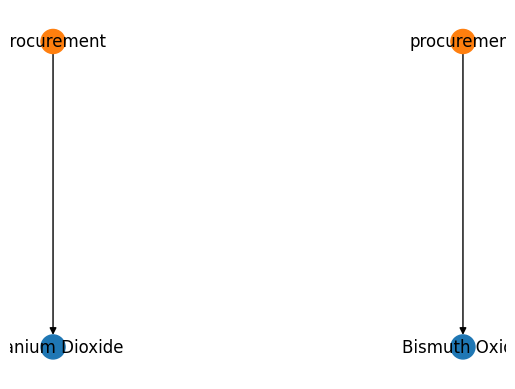

In [26]:
### A Sample is, at a high level, just a way to group nodes together. We can consider the process of chemical procurement on this day as a Sample.
s = Sample(
    name="20220930 Chemical Procurement", 
    nodes=[tio2, p0, bi2o3, p1]
)
s.plot()
sv.add(s)


Instead, we need to submit each subgraph as a separate `Sample`. Note that multiple `Sample`'s can share the same nodes and have the same name.

In [27]:
### A Sample is, at a high level, just a way to group nodes together. We can consider the process of chemical procurement on this day as a Sample.
s = Sample(
    name="20220930 Chemical Procurement", 
    nodes=[p0, tio2]
)
sv.add(s)

s = Sample(
    name="20220930 Chemical Procurement", 
    nodes=[bi2o3, p1]
)
sv.add(s)


ObjectId('64fa833e5924b71da9cb1186')

## An actual Sample -- Actions, Measurements, and Analyses that use the procured Materials

Pull the necessary actors and analysis methods

In [28]:
operator = actorview.get_by_name("Operator")[0]
tubefurnace1 = actorview.get_by_name("TubeFurnace1 30-105")[0]
aeris = actorview.get_by_name("Aeris 30-105")[0]

cnn_phaseID = actorview.get_by_name("CNN Phase ID")[0]

Pull the necessary Materials

In [31]:
mv = views.MaterialView()

tio2 = mv.find_one({
    "name": "Titanium Dioxide",
    "serial_number": "ABC123" #this is the serial number of the specific bottle I used 
})

bi2o3 = mv.find_one({
    "name": "Bismuth Oxide",
    "serial_number": "XYZ789" #this is the serial number of the specific bottle I used
})

In [32]:
# I know what was done by which actors, but thats about it.
p1 = Action(
    "grind",
    ingredients = [
        Ingredient(
            material=tio2,
            amount = 1,
            unit="g"
        ),
        Ingredient(
            material=bi2o3,
            amount = 2,
            unit="g"
        )
    ],
    actor=operator,
    instrument="mortar and pestle",
    duration="1 hour",
    )
p2 = Action(
    "sinter", 
    actor=tubefurnace1, 
    temperature_celsius=1000,
    duration_hours = 4,
)
p3 = Action(
    "grind", 
    actor=operator, 
    final_step=True,
    instrument="mortar and pestle",
    duration="1 hour", #sounds like a rough day
    )

In [33]:
s = Sample(name="realistic_sample")
s.add_linear_process(actions=[p1, p2, p3])

In [34]:
# I also know that I measured the outputs of p3. I'll make a generic output material to link to the Measurement.

m_final = s.nodes[-1]

me0 = Measurement(
    name="XRD",
    material=m_final,
    actor=aeris,
    settings = {
        "angle_min": 10,
        "angle_max": 80,
        "angle_step": 0.1,
        "exposure_time": 0.1,
    },
    data = {
        "x": [10, 20, 30, 40, 50, 60, 70, 80],
        "y": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    }
)

a0 = Analysis(
    name="Phase Identification",
    measurements=[me0],
    actor=cnn_phaseID,
    results = [
        {"phase": "TiO2", "ICSD_coll": 1234, "fraction": 0.9},
        {"phase": "TiO", "ICSD_coll": 5678, "fraction": 0.1},
    ]
)

s.add_node(me0)
s.add_node(a0)

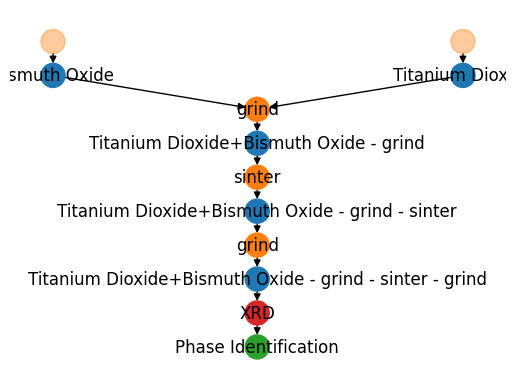

In [42]:
# Note that two Action (orange) nodes are unlabeled and transparent -- these are nodes that are not within the Sample, but are connected to nodes within the Sample. 
s.plot()

In [39]:
sv.add(s)

ObjectId('64fa83555924b71da9cb1192')

In [40]:
s.nodes

[<Material: Titanium Dioxide>,
 <Material: Bismuth Oxide>,
 <Action: grind>,
 <Material: Titanium Dioxide+Bismuth Oxide - grind>,
 <Action: sinter>,
 <Material: Titanium Dioxide+Bismuth Oxide - grind - sinter>,
 <Action: grind>,
 <Material: Titanium Dioxide+Bismuth Oxide - grind - sinter - grind>,
 <Measurement: XRD>,
 <Analysis: Phase Identification>]

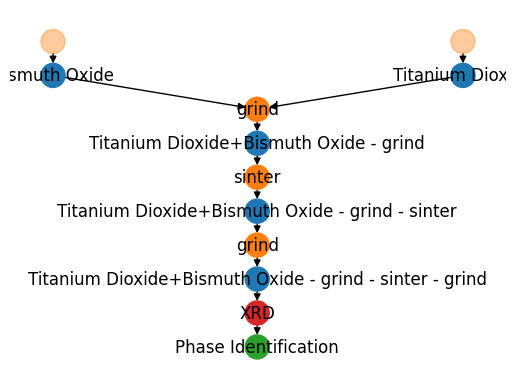

In [41]:
s.plot() #the unlabeled nodes are not contained within this Sample, but are referenced by nodes within this Sample

-----

# 4. Pulling data out of the database

In [43]:
import datetime

In [44]:
matview = views.MaterialView()

mats = matview.find(
    {"serial_number": "ABC123"},
)
print(mats)
m = mats[-1]


[<Material: Titanium Dioxide>]


In [45]:
samples = sv.get_by_material_node(m.id) #returns all Samples that contain a material node with the given id
print(samples)

[<Sample: realistic_sample>, <Sample: 20220930 Chemical Procurement>]


## Comparing Sample's

We can visually inspect `Sample` graphs 

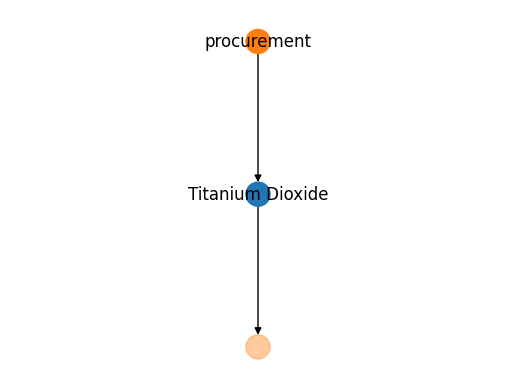

In [46]:
s = samples[-1]
s.plot()

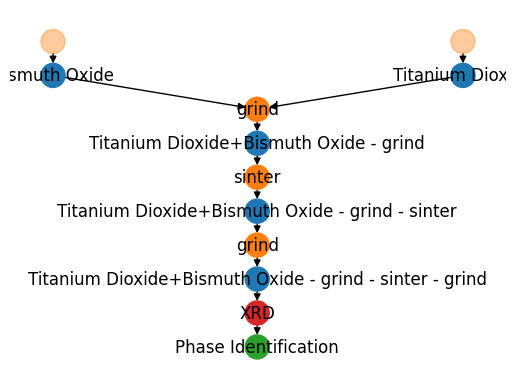

In [47]:
s = samples[0]
s.plot()

We often want to know whether `Sample`s can be compared. One way to evaluate this is to check if they followed the same processing steps (ie the same sequence of `Action`s). We can check this as the graph edit distance between graphs of only the Action nodes.

`action_sequence_distance` computes the number of edits to the action sequence to make the two Sample's identical. Note that this only considers that the _name_ of the `Action`s are the same (eg two grinding steps with different durations will be considered equivalent)

In [49]:
from labgraph.data.sample import action_sequence_distance
print(samples)

action_sequence_distance(samples[1], samples[0]) 

[<Sample: realistic_sample>, <Sample: 20220930 Chemical Procurement>]


5.0

### If we have a prototypical Sample (whether in the database or not), we can filter Sample lists to have the same action sequences

Make the prototype sample

In [50]:
# I know what was done by which actors, but thats about it.
p1 = Action(
    "grind",
    actor=operator,
    instrument="mortar and pestle",
    duration="1 hour",
    )
p2 = Action(
    "sinter", 
    actor=tubefurnace1, 
    temperature_celsius=1000,
    duration_hours = 4,
)
p3 = Action(
    "grind", 
    actor=operator, 
    final_step=True,
    instrument="mortar and pestle",
    duration="1 hour", #sounds like a rough day
    )

prototype_sample = Sample("whatever, we wont be uploading this")
prototype_sample.add_linear_process([p1, p2, p3])

In [51]:
for s in samples:
    d = action_sequence_distance(prototype_sample, s)
    result = "Match!" if d == 0 else "No Match"
    print(f"{s}:{d}\t {result}")

<Sample: realistic_sample>:0.0	 Match!
<Sample: 20220930 Chemical Procurement>:5.0	 No Match
